In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load data computed by "exp_mcmc_comparison.py"
#*****************************************************************************************************
with open('expts/mcmc_comparison-SK_nq4-22_nsamples1000_Gnm1.0_Energy.pkl', 'rb') as f: 
    SKGNM_ener=pickle.load(f)
with open('expts/mcmc_comparison-SK_nq24-24_nsamples500_Gnm1.0_Energy.pkl', 'rb') as f: 
    SKGNM_ener = pd.concat((SKGNM_ener, pickle.load(f)),ignore_index=True).reindex()
with open('expts/mcmc_comparison-SK_nq24-24_nsamples500_Gnm1.0_Energy_2.pkl', 'rb') as f: 
    SKGNM_ener = pd.concat((SKGNM_ener, pickle.load(f)),ignore_index=True).reindex()

In [5]:
def bin_data(xvalues, yvalues, xbins):
    index = np.where(np.logical_and(xvalues <= xbins[-1], xvalues > xbins[0]))
    xvalues = xvalues[index]
    yvalues = yvalues[index]
    for n in range(1, xbins.size):
        index = np.where(np.logical_and(xvalues > xbins[n-1], xvalues <= xbins[n]))
        xvalues[index] = (xbins[n-1] + xbins[n])/2
    return np.array((xvalues, yvalues)).T

## $\beta_{QAOA}$ VS $\beta_{MCMC}$

Comparison between the effective temperature of single-layer QAOA pseudo-Boltzmann states with optimal angles
and the state-of-the-art theoretical threshold of the temperature achievable by MCMC methods ($\beta_{MCMC}=1/||J||$, where $||J||$ is the largest eigenvalue of $J$).

In [6]:
def beta_Jnorm(data,save_file=False,bins=np.linspace(1, 8, 100), title=None, ylim=None):

    colors = ['slategray','cyan','blue','green','yellow','red','purple','pink','brown','coral','springgreen']
    markers= ['4','+','o',"v","^","<",">","8","s","*","p","h"]
    sns.set(rc={'figure.figsize':(15,10),"lines.linewidth": 2,"lines.markersize": 5,"font.family":"Times New Roman"},
            style='whitegrid')
    fontsize=36
    fig, ax = plt.subplots()
    all_norms = []
    all_betas = []
    allowed_N = list([int(n) for n in set(data['NºQubits'].to_numpy())])
    allowed_N.sort()
    for i,N in enumerate(allowed_N):
        subdata = data.loc[data['NºQubits']==N].reset_index()
        norms = subdata['Jnorm'].to_numpy()
        betas = subdata['Beta full energies'].to_numpy() * norms
        ax.scatter(norms, betas, color=colors[i % len(colors)], label=str(N),
                   alpha=0.5,marker=markers[i % len(markers)])
        all_norms.append(norms)
        all_betas.append(betas)
    datamed = bin_data(np.hstack(all_norms), np.hstack(all_betas), bins)
    datamed = pd.DataFrame(datamed, columns=['Normmed','Betamed'])
    ax.plot([0,8],[1.0]*2,color='orange', linewidth=3,
            label=u'Classical threshold')

    sns.lineplot(x='Normmed',y='Betamed',data=datamed,color='black', linewidth=3,label='QAOA average'
                ,err_kws={'alpha':0.5})#, err_style='bars'
    ax.set_xlabel('||J||',fontsize=fontsize)
    ax.set_ylabel(u'\u03b2$\cdot$||J||',fontsize=fontsize)
    ax.set_ylim(ylim)
    if title:
        ax.set_title(title, fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.legend(fontsize=22,handletextpad=0.3,markerscale=2,title='NºQubits',title_fontsize=22)

    if save_file:
        plt.savefig(save_file)

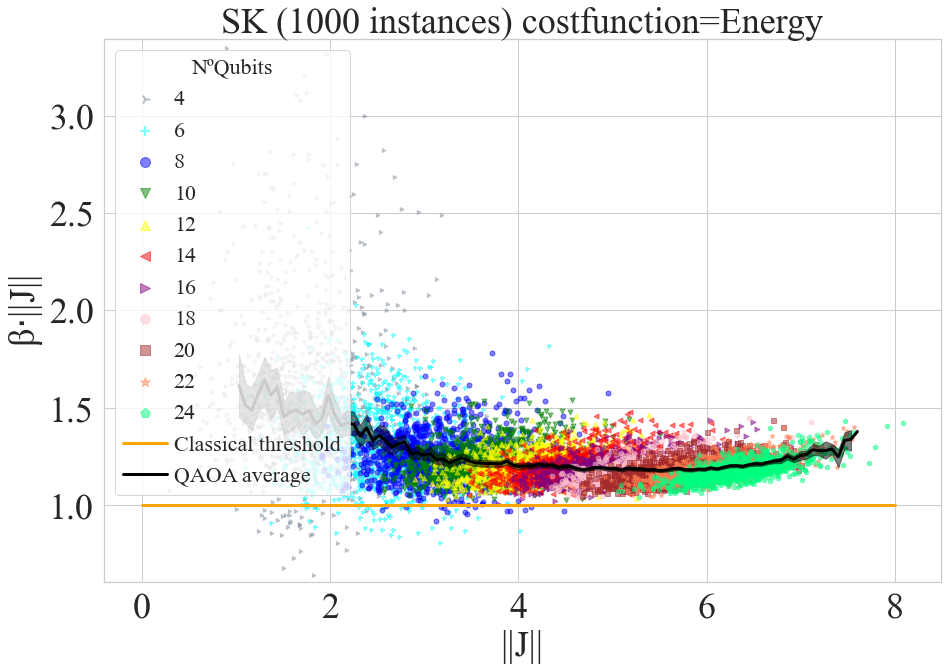

In [108]:
beta_Jnorm(SKGNM_ener,title=f'SK (1000 instances) costfunction=Energy',bins=np.linspace(1, 7.7, 100),ylim=(0.6,3.4)
,save_file='pictures\samplingadv_vsMCMC_betavsJ_SK_ener.svg')

## GS Probability VS N

Comparison between the probability amplitude of the ground state after applying the single-layer QAOA circuit with optimal angles, $P_{QAOA}$,
and the given by the minimum temperature achievable by MCMC methods, $P_{MCMC}$.

In [8]:
def prob_vsN(data, save_file=False, bins=np.linspace(1.75, 7, 100), title=None):
    sns.set(rc={'figure.figsize':(15,10),"lines.linewidth": 2,"lines.markersize": 5,"font.family":"Times New Roman"},
            style='whitegrid')
    fontsize=36
    fig, ax = plt.subplots()

    allowed_N = list([int(n) for n in set(data['NºQubits'].to_numpy())])
    allowed_N.sort()
    prob_qaoa = data['GS probability'].to_numpy()
    prob_mcmc = data['GS probability MC'].to_numpy()
    data['Log prob ratios'] = ratio = np.log(prob_qaoa / prob_mcmc)
    sns.violinplot(data=data, x='NºQubits', y='Log prob ratios')

    norms = (data['NºQubits'].to_numpy()-allowed_N[0])/2
    datamed = pd.DataFrame(np.array((norms, ratio)).T, columns=['NºQubits','Log prob ratios'])
    sns.lineplot(x='NºQubits',y='Log prob ratios',data=datamed,color='black', linewidth=3,
                 err_kws={'alpha':0.5}) #, err_style='bars'
    ax.plot([0,len(allowed_N)],[0,0],color='orange', linewidth=3)
    ax.set_xlabel(r'Size ($N$)',fontsize=fontsize)
    ax.set_ylabel(r'$\log(P_{QAOA}/P_{MCMC})$',fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    if title:
        ax.set_title(title, fontsize=fontsize)

    if save_file:
        plt.savefig(save_file)

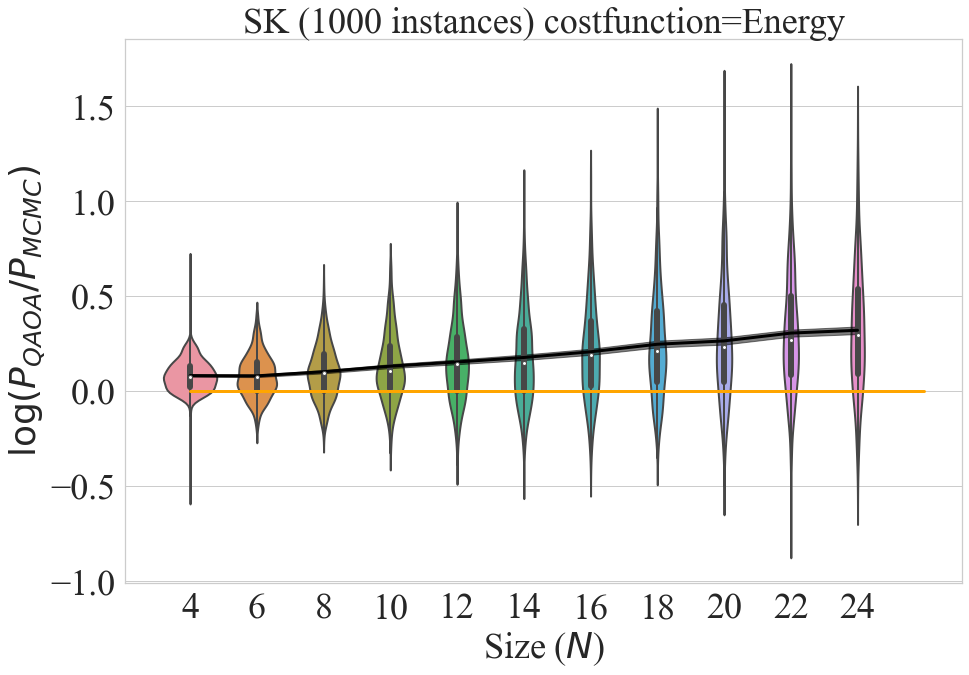

In [9]:
prob_vsN(SKGNM_ener,title=f'SK (1000 instances) costfunction=Energy',save_file='pictures\samplingadv_vsMCMC_ProbvsN_SK_ener.svg')

## GS Probability from $\beta$ VS N

Comparison between the probability amplitude of the ground state computed from the effective temperature of the QAOA pseudo-Boltzmann states with optimal angles, $P(\beta_{QAOA})$,
and the given by the minimum temperature achievable by MCMC methods, $P_{MCMC}$.

In [12]:
def probbeta_vsN(data, save_file=False, bins=np.linspace(1.75, 7, 100), title=None):
    sns.set(rc={'figure.figsize':(15,10),"lines.linewidth": 2,"lines.markersize": 5,"font.family":"Times New Roman"},
            style='whitegrid')
    fontsize=36
    fig, ax = plt.subplots()

    allowed_N = list([int(n) for n in set(data['NºQubits'].to_numpy())])
    allowed_N.sort()
    prob_qaoa = data['GS probability QAOA beta'].to_numpy()
    prob_mcmc = data['GS probability MC'].to_numpy()
    data['Log prob ratios'] = ratio = np.log(prob_qaoa / prob_mcmc)
    sns.violinplot(data=data, x='NºQubits', y='Log prob ratios')

    norms = (data['NºQubits'].to_numpy()-allowed_N[0])/2
    datamed = pd.DataFrame(np.array((norms, ratio)).T, columns=['NºQubits','Log prob ratios'])
    sns.lineplot(x='NºQubits',y='Log prob ratios',data=datamed,color='black', linewidth=3,
                 err_kws={'alpha':0.5}) #, err_style='bars'
    ax.plot([0,len(allowed_N)],[0,0],color='orange', linewidth=3)
    ax.set_xlabel(r'Size ($N$)',fontsize=fontsize)
    ax.set_ylabel(r'$\log(P(\beta_{QAOA})/P_{MCMC})$',fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    if title:
        ax.set_title(title, fontsize=fontsize)

    if save_file:
        plt.savefig(save_file)

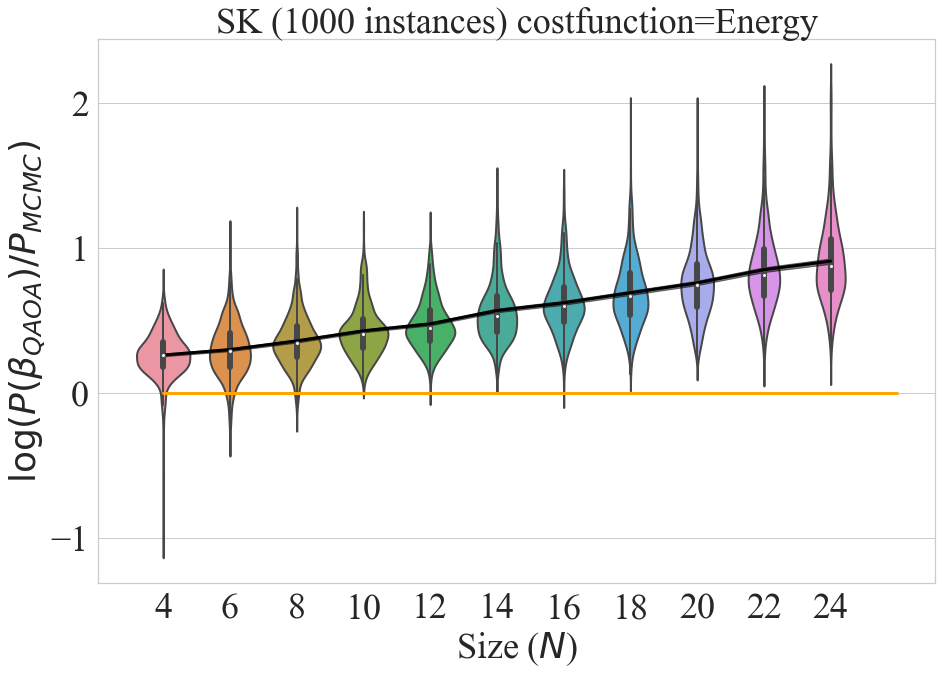

In [13]:
probbeta_vsN(SKGNM_ener,title=f'SK (1000 instances) costfunction=Energy',save_file='pictures\samplingadv_vsMCMC_ProbBetavsN_SK_ener.svg')